<h1>CellClassifier vs manual gating for PBMCs after batch effect correction</h1>

We saw in the last notebook that XGBoost provided the best performance for predicting cell populations in the FlowCAP data, so now we're going to apply this algorithm to predicting T cell subsets in our batch effect corrected data using a `FileGroup` that we will label the `Population`'s for manually.

In [2]:
# CytoPy imports
from cytopy.data.project import Project
from cytopy.data.population import Population
from cytopy.data.setup import global_init
from cytopy.data.gating_strategy import *
from cytopy.flow.cell_classifier import SklearnCellClassifier
from cytopy.flow.ref import create_ref_sample
global_init("cytopy_db")

In [3]:
# Other imports
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import pandas as pd
import numpy as np
import logging
sns.set(style="white", font_scale=1.3)
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

In [4]:
project = Project.objects(project_id="Peritonitis").get()
project.list_experiments()

['PBMC T cells', 'Corrected PBMC T cells']

In [5]:
# We're now using the Harmony corrected data
exp = project.load_experiment("Corrected PBMC T cells")

<h2>Generate training data</h2>

Using the gating infrastructure we've seen before, we will identify `Population`'s in an example `FileGroup` to then use to train an XGBoost classifier. Rather than picking an example like before, we will create some training data that is representative of all the data in our `Experiment` by randomly sampling 5000 events from each `FileGroup` and generating a new `FileGroup` called "Training Data". We can do this using the `cytopy.flow.ref.create_ref_sample` function.

In [6]:
create_ref_sample(experiment=exp, sample_size=5000, root_population="root",
                  new_file_name="Training Data")

  0%|          | 0/14 [00:00<?, ?it/s]

Now we create a `GatingStrategy`, load in our "Training Data" `FileGroup` and gate some `Population`'s we want identified.

In [7]:
gates = GatingStrategy(name="CellClassifier Labels")

In [8]:
gates.load_data(exp, "Training Data")

<AxesSubplot:xlabel='PanGD', ylabel='Vd2'>

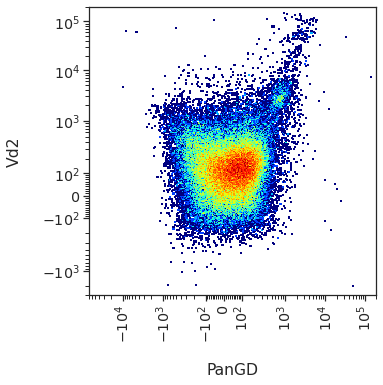

In [9]:
gates.plot_population("root", "PanGD", "Vd2", transform_x="logicle", transform_y="logicle")

<AxesSubplot:xlabel='PanGD', ylabel='Vd2'>

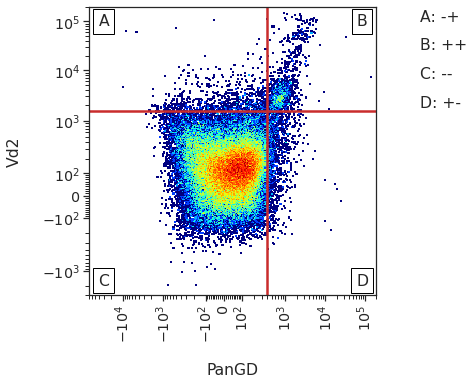

In [11]:
gdt_gate = ThresholdGate(gate_name="ManualGDTGate",
                         parent="root",
                         x="PanGD",
                         y="Vd2",
                         transform_x="logicle",
                         transform_y="logicle",
                         method="manual",
                         method_kwargs={"x_threshold": 400,
                                        "y_threshold": 1500})
gates.preview_gate(gdt_gate)

----- ManualGDTGate -----
Parent (root) n: 70000
...child Vd2+ GDTs n: 1516; 2.165714285714286% of parent
...child Not GDTs n: 68484; 97.83428571428571% of parent
------------------------


<AxesSubplot:xlabel='PanGD', ylabel='Vd2'>

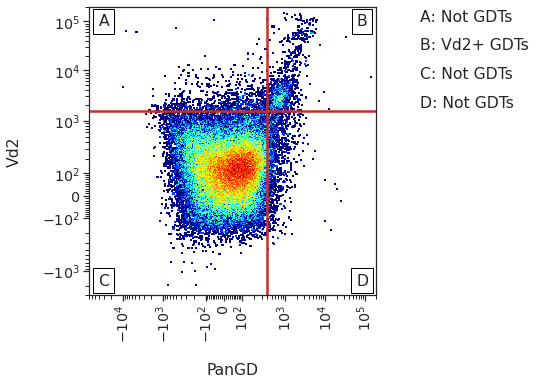

In [12]:
gdt_gate.label_children({"-+": "Not GDTs",
                         "+-": "Not GDTs",
                         "++": "Vd2+ GDTs",
                         "--": "Not GDTs"})
gates.apply_gate(gdt_gate)

<AxesSubplot:xlabel='Va7-2', ylabel='CD161'>

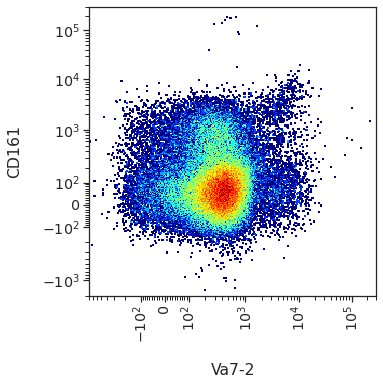

In [13]:
gates.plot_population("Not GDTs", "Va7-2", "CD161", 
                      transform_x="logicle", 
                      transform_y="logicle")

<AxesSubplot:xlabel='Va7-2', ylabel='CD161'>

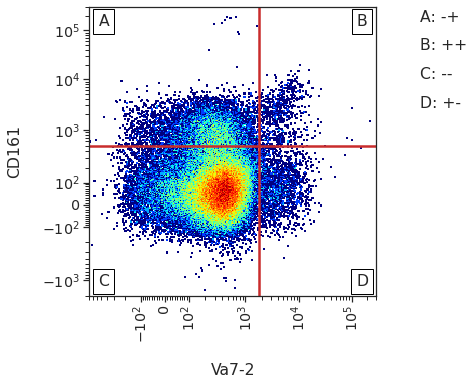

In [15]:
mait_gate = ThresholdGate(gate_name="ManualMAITGate",
                         parent="Not GDTs",
                         x="Va7-2",
                         y="CD161",
                         transform_x="logicle",
                         transform_y="logicle",
                         method="manual",
                         method_kwargs={"x_threshold": 1800,
                                        "y_threshold": 500})
gates.preview_gate(mait_gate)

----- ManualMAITGate -----
Parent (Not GDTs) n: 68484
...child MAIT cells n: 706; 1.0308977279364524% of parent
...child Classic T cells n: 67778; 98.96910227206355% of parent
------------------------


<AxesSubplot:xlabel='Va7-2', ylabel='CD161'>

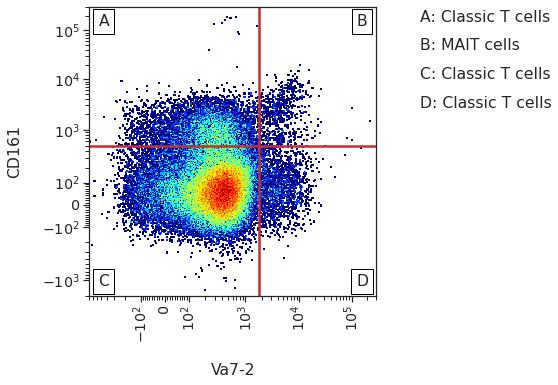

In [16]:
mait_gate.label_children({"-+": "Classic T cells",
                         "++": "MAIT cells",
                         "--": "Classic T cells",
                         "+-": "Classic T cells"})
gates.apply_gate(mait_gate)

<AxesSubplot:xlabel='CD4', ylabel='CD8'>

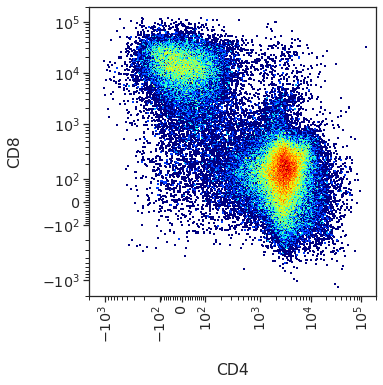

In [17]:
gates.plot_population("Classic T cells", "CD4", "CD8", 
                      transform_x="logicle", transform_y="logicle")

<AxesSubplot:xlabel='CD4', ylabel='CD8'>

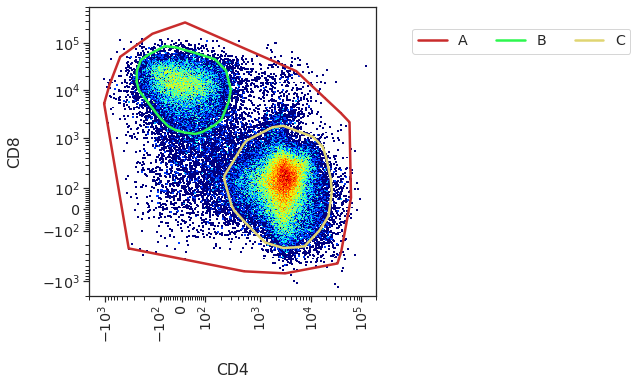

In [18]:
cd4cd8 = PolygonGate(gate_name="ManualCD4CD8Gate",
                     parent="Classic T cells",
                     x="CD4",
                     y="CD8",
                     sampling={"method": "uniform", "n": 5000},
                     transform_x="logicle",
                     transform_y="logicle",
                     method="HDBSCAN",
                     method_kwargs={"min_cluster_size": 250})
gates.preview_gate(cd4cd8)

----- ManualCD4CD8Gate -----
Parent (Classic T cells) n: 67778
...child CD8 T cells n: 16976; 25.046475257458173% of parent
...child CD4 T cells n: 45384; 66.9597804597362% of parent
------------------------


<AxesSubplot:xlabel='CD4', ylabel='CD8'>

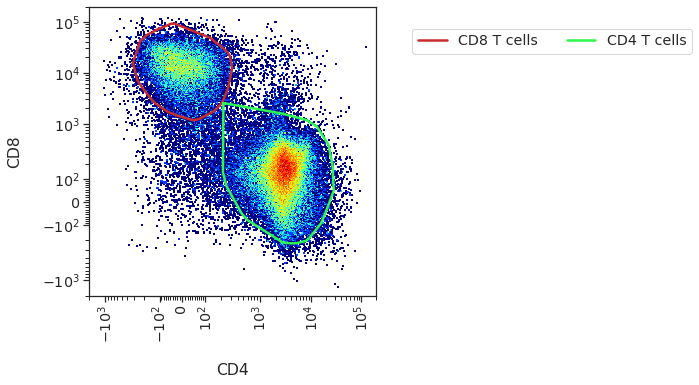

In [19]:
cd4cd8.label_children({"C": "CD4 T cells",
                       "B": "CD8 T cells"})
gates.apply_gate(cd4cd8)

In [20]:
gates.save()

<h2>Train an XGBoost classifier</h2>

With our training data ready and populated with `Population`'s, we can build an `SklearnCellClassifier` with the XGBoost classifier. 

<h3>Define classifier</h3>   

In [21]:
features = ['FSC-A', 'FSC-H', 'SSC-A', 'SSC-W', 'CXCR3', 'CD161', 'CCR7', 'Va7-2',
            'CD8', 'Vd2', 'CD45RA', 'PanGD', 'CD4', 'CD27']

In [41]:
from xgboost import XGBClassifier
params = {"learning_rate": 0.05,
          "n_estimators": 100,
          "max_depth": 4,
          "colsample_bytree": 0.75}
classifier = SklearnCellClassifier(model=XGBClassifier,
                                   params=params,
                                   features=features,
                                   target_populations=["Vd2+ GDTs",
                                                       "MAIT cells",
                                                       "CD8 T cells",
                                                       "CD4 T cells"],
                                   multi_label=False,
                                   population_prefix="XGB_")

The `CellClassifier` methods return it's mutated self and therefore chaining commands is simple. Below we load the training data, transform the data to a logicle scale, we then scale the features to have centered means and unit variance and finally we compute class weights that will be used when we call `fit` on our model; the class weights help handle class imbalance e.g. MAITs and $\gamma\delta$ T cells will be under-represented.

In [42]:
classifier = (classifier.load_training_data(experiment=exp,
                                          reference='Training Data',
                                          root_population='root')
              .transform(method="logicle")
              .scale()
              .compute_class_weights())

The `CellClassifier` class and it's children have many convenient methods to help inspect the performance of our model. We can use `fit_cv` and pass any valid Scikit-Learn cross-validator to perform cross-validaiton and get the average performance across train and test sets.

In [43]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5,
                      random_state=42,
                      shuffle=True)

<h3>Cross validation and learning curves</h3>

In [44]:
training_results, testing_results = classifier.fit_cv(skf)

  0%|          | 0/5 [00:00<?, ?it/s]

In [45]:
training_u = pd.DataFrame(training_results).mean()
training_std = pd.DataFrame(training_results).std()
training_u.name = "Average training score"
training_std.name = "Training score SD"
pd.DataFrame([training_u, training_std])

,balanced_accuracy_score,f1_weighted,roc_auc_score
Average training score,0.989201,0.988634,0.999783
Training score SD,0.000249,0.000463,0.000008


In [46]:
testing_u = pd.DataFrame(testing_results).mean()
testing_std = pd.DataFrame(testing_results).std()
testing_u.name = "Average testing score"
testing_std.name = "Testing score SD"
pd.DataFrame([testing_u, testing_std])

,balanced_accuracy_score,f1_weighted,roc_auc_score
Average testing score,0.984516,0.985681,0.999575
Testing score SD,0.001168,0.000285,0.000056


We can see very good performance for both training and testing, but ensure we're not being fooled we can plot a learning curve to be certain that our model is not overfitting. Below the learning curve shows the training and cross-validation holdout performance whilst varying the training size. We see that as the training size increases, the performance converges.

[learning_curve] Training set sizes: [ 5600 11200 16800 22400 28000 33600 39200 44800 50400 56000]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.5min finished


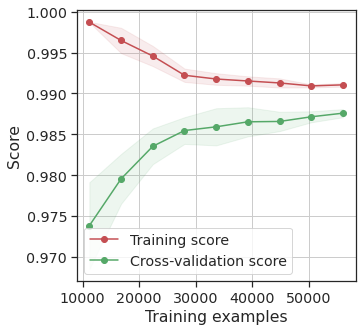

In [47]:
ax = classifier.plot_learning_curve(n_jobs=-1, scoring="accuracy")
plt.savefig("figures/xgboost/learning_curve.png", 
            dpi=300, 
            facecolor="white", 
            bbox_inches="tight")

If we want to see the performance of our classifier for individual cell populations, we can generate a confusion matrix:

In [48]:
classifier.fit()

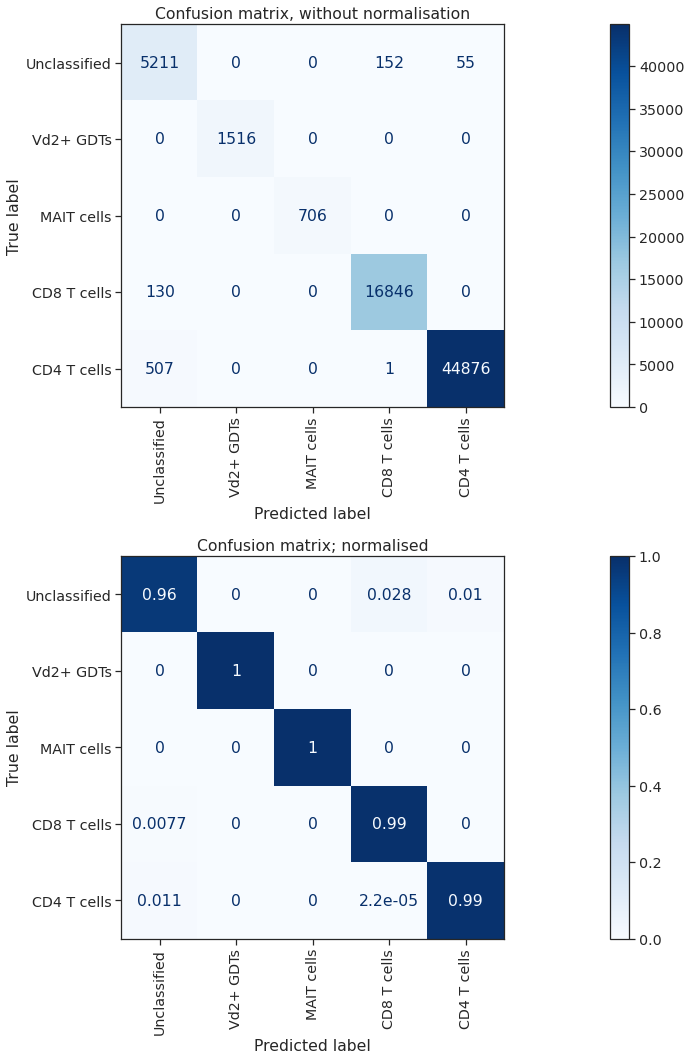

In [49]:
classifier.plot_confusion_matrix(figsize=(30, 15))
plt.savefig("figures/xgboost/confusion_matrix.png", dpi=300, facecolor="white", bbox_inches="tight")
plt.show()

<h2>Make predictions for remaining samples</h2>

To use this model we have trained to predict the `Population`'s in the remaining `FileGroup`'s of our `Experiment`, we use the `predict` method. We loop over the `FileGroup`'s in our `Experiment` and call `predict` for each of them. The result is a modified `FileGroup` with the predicted `Population`'s now appended. We can then simply call `save` and commit these changes to the database.

In [52]:
from tqdm.notebook import tqdm
for s in tqdm(exp.list_samples()):
    if s == "Training Data":
        continue
    prediction = classifier.predict(experiment=exp,
                                    sample_id=s,
                                    root_population="root",
                                    return_predictions=False)[0]
    prediction.save()

  0%|          | 0/15 [00:00<?, ?it/s]

<h2>Comparisons with manual gating</h2>

Below we use a newly generated predicitons and compare them to the same populations idenfied by manual gates.

In [13]:
xgb_results = exp.population_statistics()
xgb_results["sample_id"] = xgb_results["sample_id"].apply(lambda x: x.replace("Corrected_", ""))

In [14]:
manual_gates = pd.read_csv("manual_gates1.csv")
sample_ids = manual_gates.sample_id.values
populations = manual_gates.columns.to_list()[0:5]
manual_gates = manual_gates[populations].copy()
populations = manual_gates.columns.to_list()[1:]
for x in populations:
    manual_gates[f"{x} % of CD3+"] = manual_gates[x]/manual_gates["Live single CD3+ cells"] 
manual_gates["sample_id"] = sample_ids

In [15]:
def auto_vs_manual(manual_population: str,
                   auto_population: str,
                   manual_stats: pd.DataFrame,
                   auto_stats: pd.DataFrame,
                   title: str):
    auto = (auto_stats[auto_stats.population_name == auto_population]
            [["sample_id", "frac_of_root"]]
            .rename({"frac_of_root": "Auto"}, axis=1))
    manual = (manual_stats[["sample_id", manual_population]]
              .rename({manual_population: "Manual"}, axis=1))
    stats = auto.merge(manual, on="sample_id")
    stats["Auto"] = stats["Auto"]*100
    stats["Manual"] = stats["Manual"]*100
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.scatter(stats.Auto.values, 
               stats.Manual.values,
               edgecolor="black",
               color="#4e7abf",
               s=120,
               linewidth=2,
               zorder=1)
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle="--", color="black", zorder=0)
    axis_lower_lim = np.min([np.min(ax.get_xlim()),
                             np.min(ax.get_ylim())])
    axis_upper_lim = np.max([np.max(ax.get_xlim()),
                             np.max(ax.get_ylim())])
    ax.set_xlim((axis_lower_lim, axis_upper_lim))
    ax.set_ylim((axis_lower_lim, axis_upper_lim))
    ax.locator_params(axis='y', nbins=6)
    ax.locator_params(axis='x', nbins=6)
    ax.set_xlabel("Autonomous gates")
    ax.set_ylabel("Manual gates")
    ax.set_title(title)
    return ax, stats

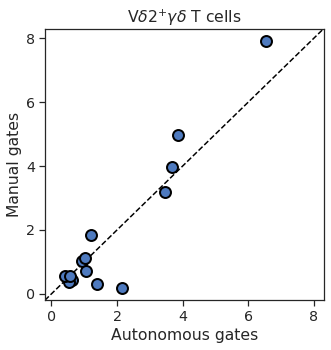

In [17]:
auto_vs_manual("Vd2+ GDTs % of CD3+",
               "XGB__Vd2+ GDTs",
               manual_gates,
               xgb_results,
               title="V$\delta 2^{+} \gamma\delta$ T cells")[0]
plt.savefig("figures/xgboost/gdt_manualvsauto.png", dpi=300, facecolor="white", bbox_inches="tight")

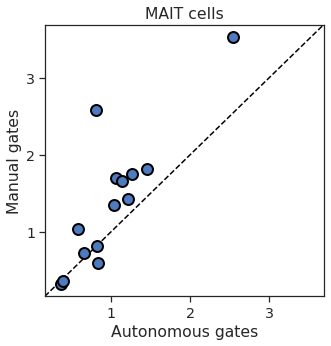

In [18]:
ax, stats = auto_vs_manual("MAIT cells % of CD3+",
               "XGB__MAIT cells",
               manual_gates,
               xgb_results,
               title="MAIT cells")
plt.savefig("figures/xgboost/maits_manualvsauto.png", dpi=300, facecolor="white", bbox_inches="tight")

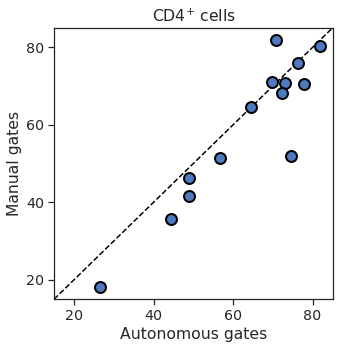

In [19]:
ax, stats = auto_vs_manual("CD4+ CD8- T cells % of CD3+",
               "XGB__CD4 T cells",
               manual_gates,
               xgb_results,
               title="CD$4^{+}$ cells")
plt.savefig("figures/xgboost/cd4_manualvsauto.png", dpi=300, facecolor="white", bbox_inches="tight")

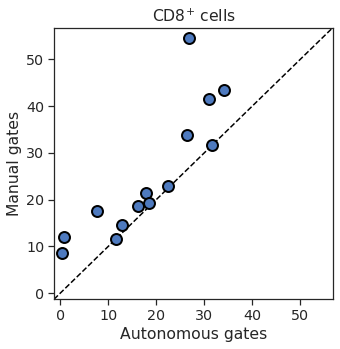

In [20]:
ax, stats = auto_vs_manual("CD4- CD8+ T cells % of CD3+",
               "XGB__CD8 T cells",
               manual_gates,
               xgb_results,
               title="CD$8^{+}$ cells")
plt.savefig("figures/xgboost/cd8_manualvsauto.png", dpi=300, facecolor="white", bbox_inches="tight")